<a href="https://colab.research.google.com/github/fabricejumel/FNST_google_collab_training/blob/main/facestyliser/Test_mediapipe_landmark_FAIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installation des dépendances (version MediaPipe Tasks)
!pip install mediapipe==0.10.11 opencv-python matplotlib numpy

import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os

# NOUVELLE API MediaPipe Tasks (face_landmarker)
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

print("✅ MediaPipe Tasks installé - Nouvelle API face_landmarker")

# Upload image de test (conservée pour les tests suivants)
print("Upload votre image de test (jpg/png):")
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]
print(f"Image chargée: {image_filename}")

# Chargement de l'image
image = cv2.imread(image_filename)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape
print(f"Image size: {w}x{h}")




ERROR: Could not find a version that satisfies the requirement mediapipe==0.10.11 (from versions: 0.10.13, 0.10.14, 0.10.15, 0.10.18, 0.10.20, 0.10.21)
ERROR: No matching distribution found for mediapipe==0.10.11
✅ MediaPipe Tasks installé - Nouvelle API face_landmarker
Upload votre image de test (jpg/png):


Saving test_11.png to test_11.png
Image chargée: test_11.png
Image size: 1000x773


Nombre de landmarks détectés: 478
👁️ Déplacement yeux appliqué: +0x, -30y, +0z


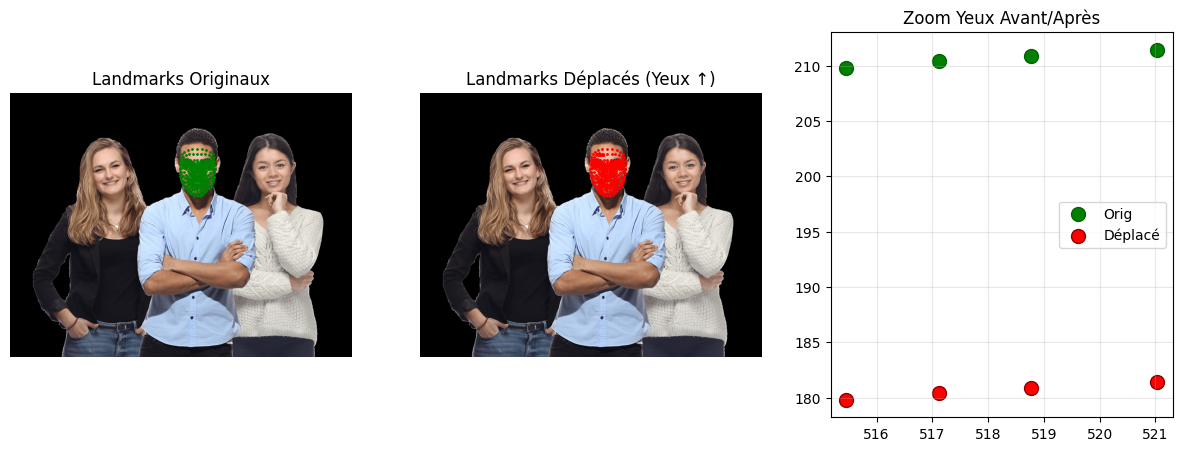

✅ Test déplacement réussi!


In [5]:
# Téléchargement du modèle Face Landmarker
!wget -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

# Configuration Face Landmarker (nouvelle API)
BaseOptions = python.BaseOptions
FaceLandmarker = vision.FaceLandmarker
FaceLandmarkerOptions = vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

base_options = BaseOptions(model_asset_path='./face_landmarker.task')
options = FaceLandmarkerOptions(
    base_options=base_options,
    running_mode=VisionRunningMode.IMAGE,
    output_face_blendshapes=True,
    output_facial_transformation_matrixes=True
)
detector = FaceLandmarker.create_from_options(options)

# Détection des landmarks
mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
detection_result = detector.detect(mp_image)

if detection_result.face_landmarks:
    landmarks = detection_result.face_landmarks[0]  # Premier visage

    # ✅ FIX: Conversion CORRECTE NormalizedLandmark → pixels
    landmarks_array = np.array([[lm.x * w, lm.y * h, lm.z * 100] for lm in landmarks])
    print(f"Nombre de landmarks détectés: {len(landmarks)}")

    # TEST DÉPLACEMENT: Déplacement des yeux vers le haut
    eye_indices = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]
    displacement = np.array([0, -30, 0])  # Y=-30 pixels (vers le haut)

    landmarks_array_new = landmarks_array.copy()
    landmarks_array_new[eye_indices] += displacement
    print("👁️ Déplacement yeux appliqué: +0x, -30y, +0z")

    # Visualisation landmarks originaux (VERT)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image_rgb)
    for (x, y, _) in landmarks_array:
        plt.plot(x, y, 'go', markersize=1)
    plt.title('Landmarks Originaux')
    plt.axis('off')

    # Visualisation landmarks déplacés (ROUGE)
    plt.subplot(1,3,2)
    plt.imshow(image_rgb)
    for (x, y, _) in landmarks_array_new:
        plt.plot(x, y, 'ro', markersize=1)
    plt.title('Landmarks Déplacés (Yeux ↑)')
    plt.axis('off')

    # Zoom yeux avant/après
    plt.subplot(1,3,3)
    eye_orig = landmarks_array[eye_indices[:4]]
    eye_new = landmarks_array_new[eye_indices[:4]]
    plt.scatter(eye_orig[:,0], eye_orig[:,1], c='green', s=100, label='Orig', edgecolors='darkgreen')
    plt.scatter(eye_new[:,0], eye_new[:,1], c='red', s=100, label='Déplacé', edgecolors='darkred')
    plt.legend()
    plt.title('Zoom Yeux Avant/Après')
    plt.grid(True, alpha=0.3)
    plt.show()

    print("✅ Test déplacement réussi!")

    # ✅ Variables globales pour Cellule 3
    globals()['landmarks_orig'] = landmarks_array
    globals()['landmarks_new'] = landmarks_array_new
else:
    print("❌ Aucun visage détecté")


🎯 Calcul warp avec landmarks...


/tmp/ipython-input-4156934032.py:50: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


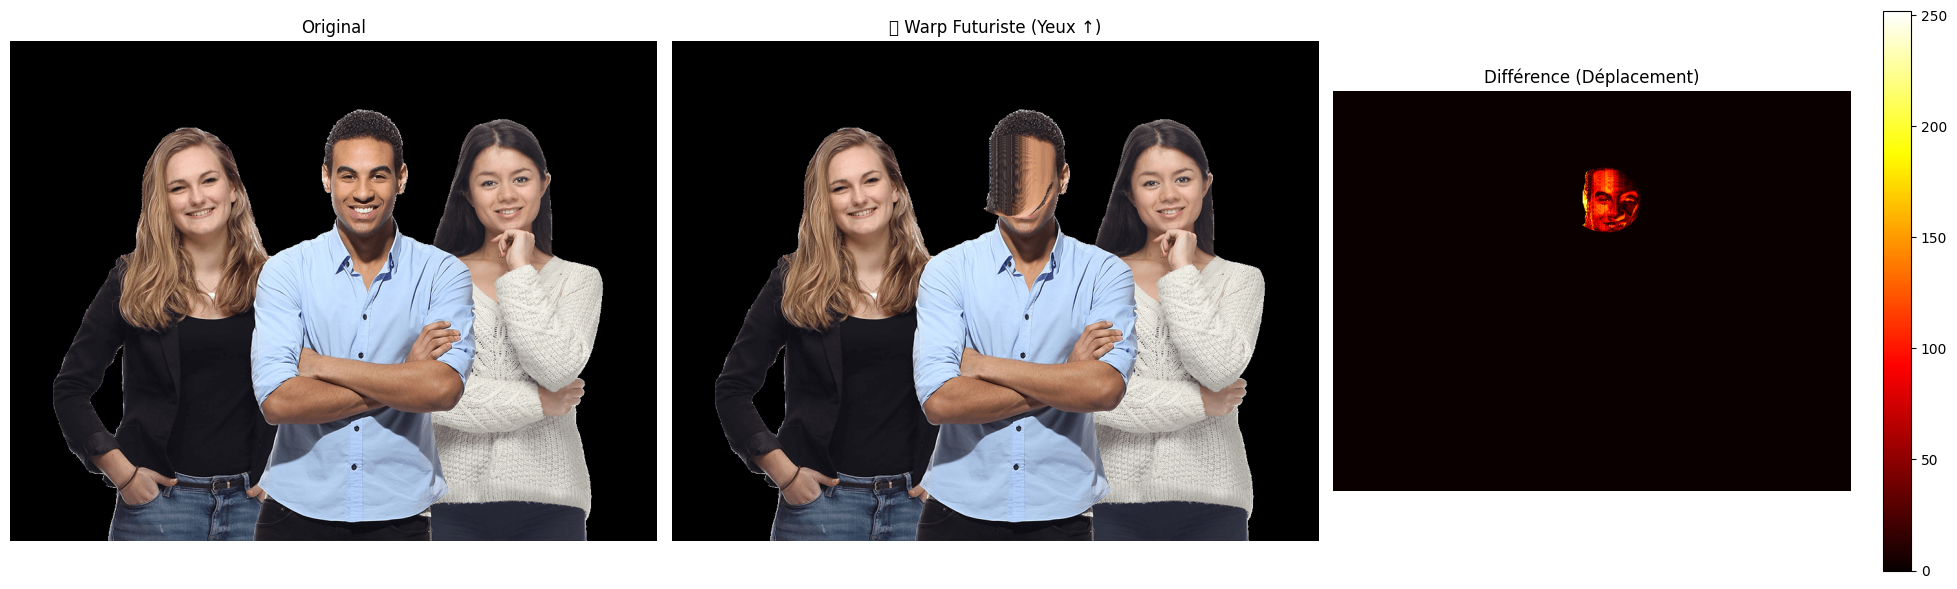

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 Image warped téléchargée!
✅ Variables globales créées


In [7]:
def warp_image_with_landmarks(image, orig_landmarks, new_landmarks, num_landmarks=478):
    h, w = image.shape[:2]
    map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)

    for i in range(num_landmarks):
        dx = new_landmarks[i,0] - orig_landmarks[i,0]
        dy = new_landmarks[i,1] - orig_landmarks[i,1]

        # ✅ FIX: Calcul distance sur grille entière
        dist = np.sqrt((map_x-orig_landmarks[i,0])**2 + (map_y-orig_landmarks[i,1])**2)
        mask = dist < 60

        if np.any(mask):
            # ✅ FIX: Weight même shape que mask
            weight = np.exp(-dist[mask]/25)
            # Extension weight à la forme complète de mask
            weight_full = np.zeros_like(map_x)
            weight_full[mask] = weight

            map_x += dx * weight_full
            map_y += dy * weight_full

    warped_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    return warped_image

# Application du warp
if 'landmarks_orig' in globals() and 'landmarks_new' in globals():
    print("🎯 Calcul warp avec landmarks...")
    warped = warp_image_with_landmarks(image_rgb, landmarks_orig, landmarks_new)

    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    plt.imshow(image_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(warped)
    plt.title('🚀 Warp Futuriste (Yeux ↑)')
    plt.axis('off')

    diff = cv2.absdiff(image_rgb.astype(np.float32), warped.astype(np.float32))
    plt.subplot(1,3,3)
    plt.imshow(np.mean(diff, axis=2), cmap='hot')
    plt.title('Différence (Déplacement)')
    plt.colorbar()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    cv2.imwrite('test_warped_landmarks.jpg', cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))
    files.download('test_warped_landmarks.jpg')
    print("🚀 Image warped téléchargée!")

    globals()['test_image'] = image_rgb
    globals()['test_warped'] = warped
    print("✅ Variables globales créées")
else:
    print("❌ Exécutez d'abord la Cellule 2!")



🔥 Calcul YEUX x4...
🎯 Centre œil gauche: [516.28503203 210.10940272]
🎯 Centre œil droit: [519.89999413 211.16522041]


/tmp/ipython-input-809357269.py:96: UserWarning: Glyph 128065 (\N{EYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128065 (\N{EYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


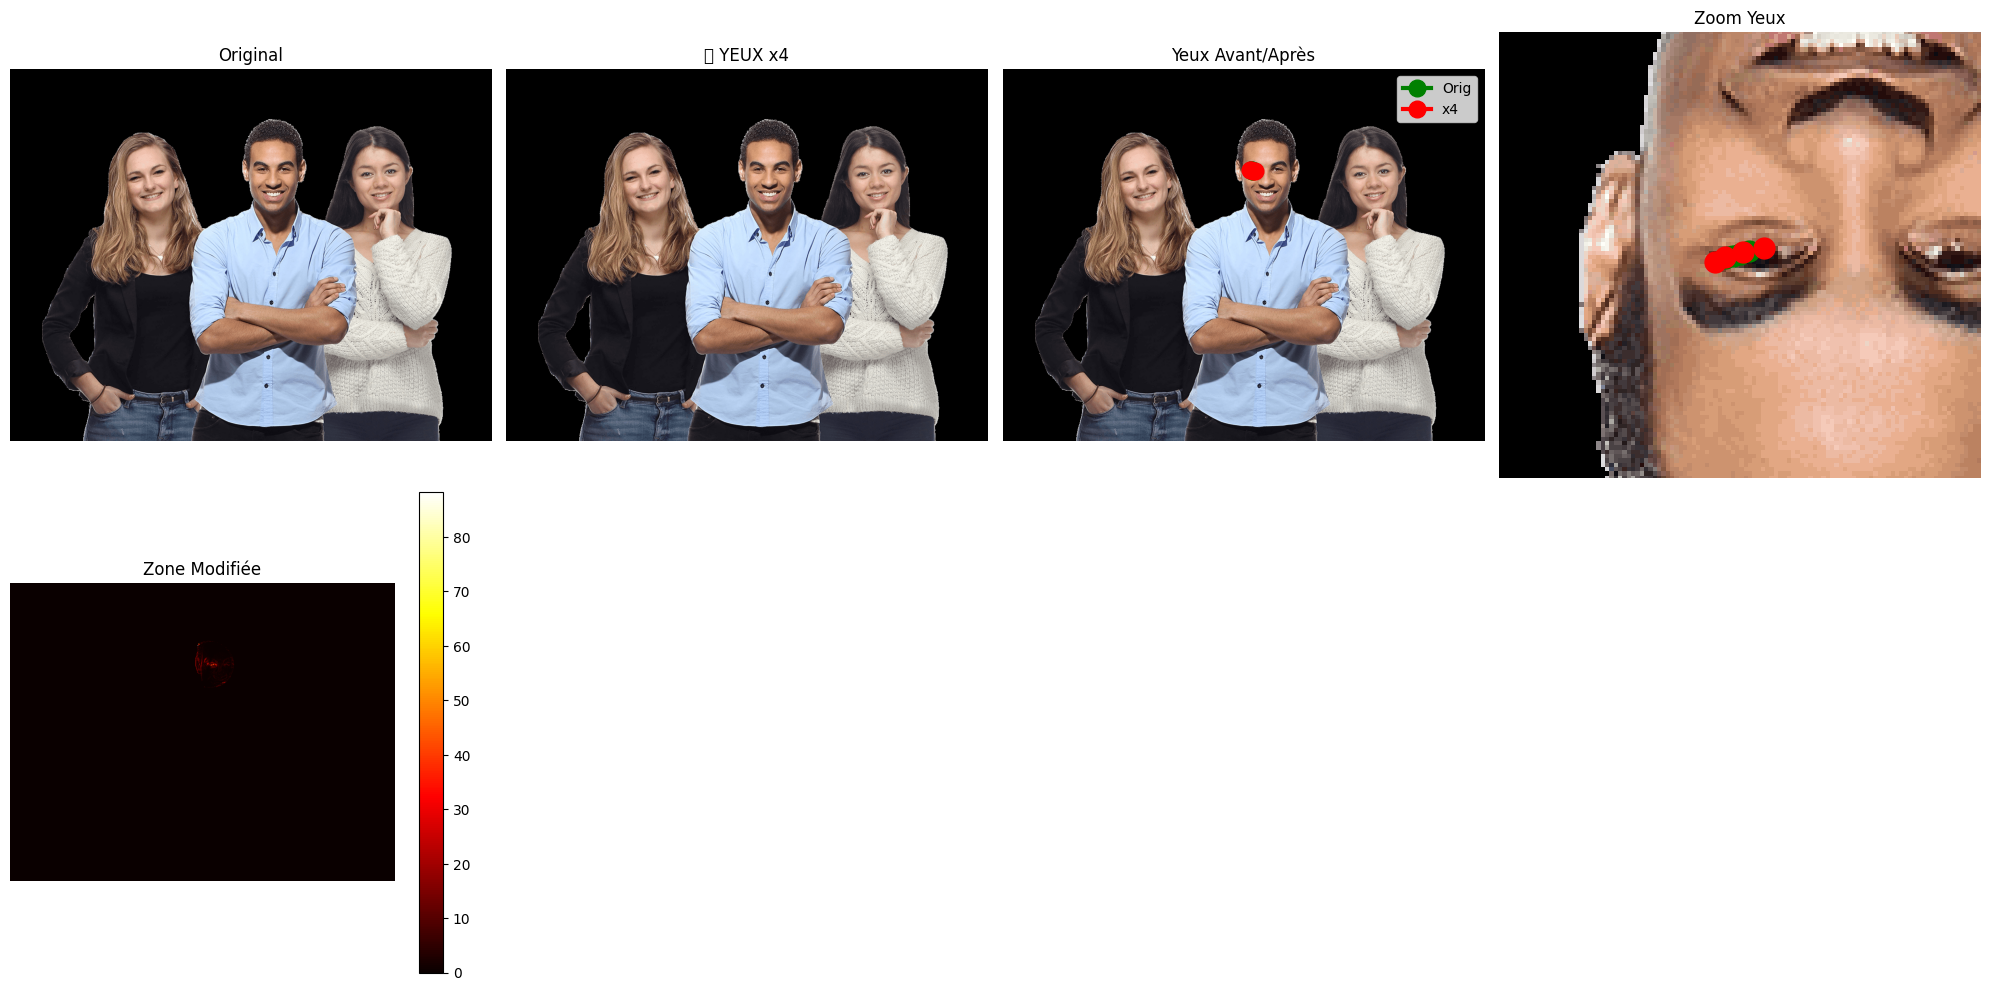

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

👁️🚀 YEUX x4 prêt!


In [9]:
def enlarge_eyes_x4(image, landmarks_orig):
    """Grossit les yeux x4 en déplaçant les landmarks vers l'extérieur"""
    h, w = image.shape[:2]
    map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)

    eye_indices = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 161, 246]

    # ✅ FIX: Calcul centres yeux SIMPLE
    left_eye_center = np.mean(landmarks_orig[[33, 7]], axis=0)   # [x,y,z]
    right_eye_center = np.mean(landmarks_orig[[163, 144]], axis=0)

    print(f"🎯 Centre œil gauche: {left_eye_center[:2]}")
    print(f"🎯 Centre œil droit: {right_eye_center[:2]}")

    # Création landmarks modifiés
    landmarks_new = landmarks_orig.copy()

    # Grossissement x4 pour coins des yeux seulement
    for idx in [33, 7]:  # Œil gauche
        vec = landmarks_orig[idx][:2] - left_eye_center[:2]
        landmarks_new[idx][:2] = left_eye_center[:2] + vec * 4.0

    for idx in [163, 144]:  # Œil droit
        vec = landmarks_orig[idx][:2] - right_eye_center[:2]
        landmarks_new[idx][:2] = right_eye_center[:2] + vec * 4.0

    # Application warp sur TOUS les landmarks déplacés
    for i in range(len(landmarks_orig)):
        dx = landmarks_new[i,0] - landmarks_orig[i,0]
        dy = landmarks_new[i,1] - landmarks_orig[i,1]

        dist = np.sqrt((map_x-landmarks_orig[i,0])**2 + (map_y-landmarks_orig[i,1])**2)
        mask = dist < 60

        if np.any(mask):
            weight = np.exp(-dist[mask]/25)
            weight_full = np.zeros_like(map_x)
            weight_full[mask] = weight
            map_x += dx * weight_full
            map_y += dy * weight_full

    warped_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    return warped_image, landmarks_new

# 🎯 GROSSIR YEUX x4
if 'landmarks_orig' in globals():
    print("🔥 Calcul YEUX x4...")
    warped_eyes_x4, landmarks_eyes_x4 = enlarge_eyes_x4(image_rgb, landmarks_orig)

    # Visualisation COMPLÈTE
    plt.figure(figsize=(20,10))

    plt.subplot(2,4,1)
    plt.imshow(image_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2,4,2)
    plt.imshow(warped_eyes_x4)
    plt.title('👁️ YEUX x4')
    plt.axis('off')

    # Landmarks YEUX seulement
    plt.subplot(2,4,3)
    plt.imshow(image_rgb)
    eye_pts_orig = landmarks_orig[[33,7,163,144]]
    eye_pts_new = landmarks_eyes_x4[[33,7,163,144]]
    plt.plot(eye_pts_orig[:,0], eye_pts_orig[:,1], 'go-', linewidth=3, markersize=12, label='Orig')
    plt.plot(eye_pts_new[:,0], eye_pts_new[:,1], 'ro-', linewidth=3, markersize=12, label='x4')
    plt.legend()
    plt.title('Yeux Avant/Après')
    plt.axis('off')

    # Zoom yeux
    plt.subplot(2,4,4)
    minx, maxx = min(eye_pts_orig[:,0].min(), eye_pts_new[:,0].min()), max(eye_pts_orig[:,0].max(), eye_pts_new[:,0].max())
    miny, maxy = min(eye_pts_orig[:,1].min(), eye_pts_new[:,1].min()), max(eye_pts_orig[:,1].max(), eye_pts_new[:,1].max())
    plt.imshow(image_rgb)
    plt.xlim(minx-50, maxx+50)
    plt.ylim(miny-50, maxy+50)
    plt.plot(eye_pts_orig[:,0], eye_pts_orig[:,1], 'go-', markersize=15)
    plt.plot(eye_pts_new[:,0], eye_pts_new[:,1], 'ro-', markersize=15)
    plt.title('Zoom Yeux')
    plt.axis('off')

    # Différence
    diff = cv2.absdiff(image_rgb.astype(np.float32), warped_eyes_x4.astype(np.float32))
    plt.subplot(2,4,5)
    plt.imshow(np.mean(diff, axis=2), cmap='hot')
    plt.title('Zone Modifiée')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    cv2.imwrite('eyes_x4_futuriste.jpg', cv2.cvtColor(warped_eyes_x4, cv2.COLOR_RGB2BGR))
    files.download('eyes_x4_futuriste.jpg')
    print("👁️🚀 YEUX x4 prêt!")

    globals()['eyes_x4_warped'] = warped_eyes_x4
    globals()['landmarks_eyes_x4'] = landmarks_eyes_x4


🔥 Agrandissement visage x1.5...
🎯 Centre visage: [546.8534831  234.71619584]


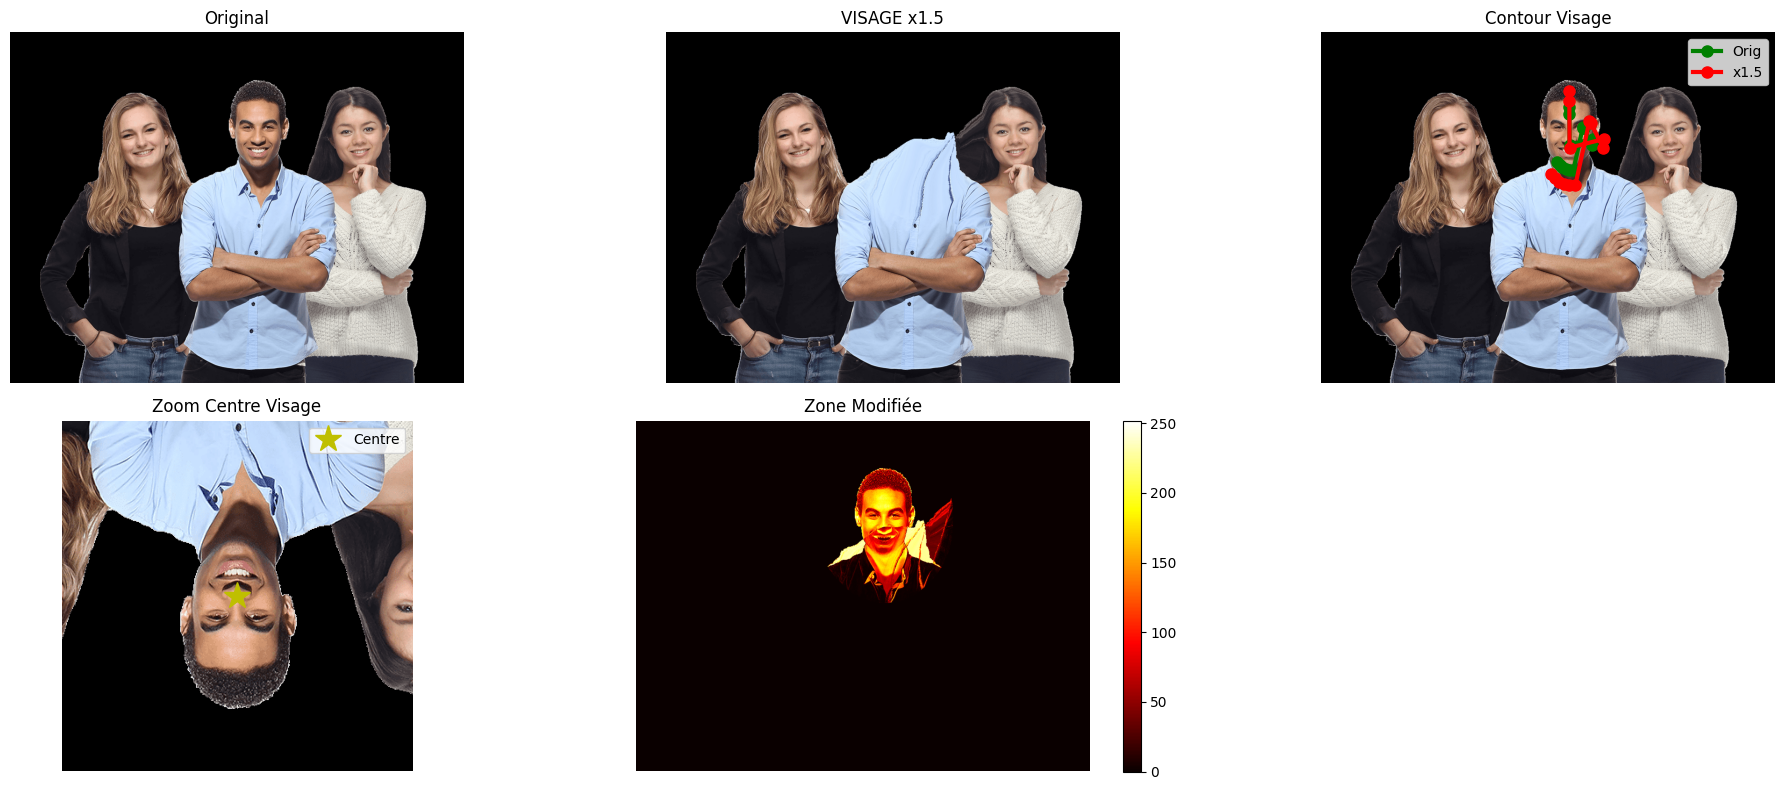

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ VISAGE x1.5 téléchargé!


In [11]:
def scale_face_x15(image, landmarks_orig, scale=1.5):
    """Agrandi TOUT le visage x1.5 depuis le centre"""
    h, w = image.shape[:2]
    map_x, map_y = np.meshgrid(np.arange(w), np.arange(h))
    map_x = map_x.astype(np.float32)
    map_y = map_y.astype(np.float32)

    # ✅ CENTRE DU VISAGE (moyenne tous landmarks)
    face_center = np.mean(landmarks_orig[:, :2], axis=0)

    # Création landmarks scalés
    landmarks_new = landmarks_orig.copy()
    for i in range(len(landmarks_orig)):
        vec = landmarks_orig[i, :2] - face_center
        landmarks_new[i, :2] = face_center + vec * scale

    # Warp FLUIDE sur TOUS les landmarks
    for i in range(len(landmarks_orig)):
        dx = landmarks_new[i,0] - landmarks_orig[i,0]
        dy = landmarks_new[i,1] - landmarks_orig[i,1]

        dist = np.sqrt((map_x-landmarks_orig[i,0])**2 + (map_y-landmarks_orig[i,1])**2)
        mask = dist < 100

        if np.any(mask):
            weight = np.exp(-dist[mask]/40)
            weight_full = np.zeros_like(map_x)
            weight_full[mask] = weight
            map_x += dx * weight_full * 0.8
            map_y += dy * weight_full * 0.8

    warped_image = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    return warped_image, landmarks_new, face_center  # ✅ RETURN face_center

# 🎯 VISAGE x1.5
if 'landmarks_orig' in globals():
    print("🔥 Agrandissement visage x1.5...")
    warped_face_x15, landmarks_face_x15, face_center = scale_face_x15(image_rgb, landmarks_orig, scale=1.5)

    print(f"🎯 Centre visage: {face_center}")

    # Visualisation
    plt.figure(figsize=(20,8))

    plt.subplot(2,3,1)
    plt.imshow(image_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2,3,2)
    plt.imshow(warped_face_x15)
    plt.title('VISAGE x1.5')
    plt.axis('off')

    # Landmarks comparaison (contour visage)
    face_contour = [10, 151, 94, 323, 361, 263, 466, 388, 377, 152, 148, 176, 149, 150]
    plt.subplot(2,3,3)
    plt.imshow(image_rgb)
    plt.plot(landmarks_orig[face_contour,0], landmarks_orig[face_contour,1], 'go-', linewidth=3, markersize=8, label='Orig')
    plt.plot(landmarks_face_x15[face_contour,0], landmarks_face_x15[face_contour,1], 'ro-', linewidth=3, markersize=8, label='x1.5')
    plt.legend()
    plt.title('Contour Visage')
    plt.axis('off')

    # ZOOM centre ✅ FIX
    plt.subplot(2,3,4)
    plt.imshow(image_rgb)
    plt.plot(face_center[0], face_center[1], 'y*', markersize=20, label='Centre')
    plt.xlim(face_center[0]-200, face_center[0]+200)
    plt.ylim(face_center[1]-200, face_center[1]+200)
    plt.title('Zoom Centre Visage')
    plt.legend()
    plt.axis('off')

    # Différence
    diff = cv2.absdiff(image_rgb.astype(np.float32), warped_face_x15.astype(np.float32))
    plt.subplot(2,3,5)
    plt.imshow(np.mean(diff, axis=2), cmap='hot')
    plt.title('Zone Modifiée')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    cv2.imwrite('face_x15_futuriste.jpg', cv2.cvtColor(warped_face_x15, cv2.COLOR_RGB2BGR))
    files.download('face_x15_futuriste.jpg')
    print("✅ VISAGE x1.5 téléchargé!")

    globals()['face_x15_warped'] = warped_face_x15
